<a href="https://colab.research.google.com/github/SangminAhn21/DL_Study/blob/main/Python_DeepLearning_PyTorch/PART_02/MNIST_MLP_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device: ', DEVICE)

Using PyTorch version: 1.9.0+cu111  Device:  cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
train_dataset = datasets.MNIST(root = '../data/MNIST',
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = '../data/MNIST',
                              train = False,
                              transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
for (x_train, y_train) in train_loader:
  print("x_train:", x_train.size(), 'type:', x_train.type())
  print("y_train:", y_train.size(), 'type:', y_train.type())
  break

x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


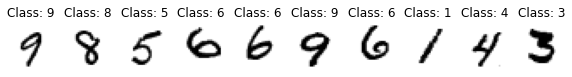

In [7]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  plt.imshow(x_train[i, :, :, :].numpy().reshape(28, 28), cmap = 'gray_r')
  plt.title('Class: ' + str(y_train[i].item()))

In [18]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(28 * 28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)
    self.dropout_prob = 0.5
    self.batch_norm1 = nn.BatchNorm1d(512)
    self.batch_norm2 = nn.BatchNorm1d(256)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.fc1(x)
    x = self.batch_norm1(x)
    x = F.relu(x)
    x = F.dropout(x, training = self.training, p = self.dropout_prob)
    x = self.fc2(x)
    x = self.batch_norm2(x)
    x = F.relu(x)
    x = F.dropout(x, training = self.training, p = self.dropout_prob)
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    return x

In [26]:
import torch.nn.init as init

def weight_init(m):
  if isinstance(m, nn.Linear):
    init.kaiming_uniform_(m.weight.data)

model = Net().to(DEVICE)
model.apply(weight_init)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)


Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [20]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}'.format(
            Epoch, batch_idx * len(image),
            len(train_loader.dataset), 100. * batch_idx / len(train_loader),
            loss.item()))

In [16]:
def evaluate(model, test_laoder):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdims=True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()
    
  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [27]:
for Epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print('\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n'.
        format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.994639
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.820699
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.524985
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.477798
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.254153
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.372076
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.527089
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.245145
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.453706
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.271837

[EPOCH: 1], 	Test Loss: 0.0040, 	Test Accuracy: 96.24 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.397017
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.246039
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.242983
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.192290
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.323299
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.157732
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.349389
Train Epoch: 2 [448